# Training and evaluating Singing Voice Detectors

In [1]:
import sys
sys.path.append('../vocaldetection/')
import sklearn
import utils
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import librosa
import numpy as np
from scipy.io import arff
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score, accuracy_score
%matplotlib inline

I know that the best parameters for training SVM and RF on this dataset are C=0.1 for SVM and nE=100 for RF. [WHY??]

Then, I can just train the models with these parameters and see how the results on confusion changes.

For each set of descriptors, I can do a cross validation evaluation and see the accuracy for each classifier.

Then, I select the greater accuracy to be my reference of ceiling confusion.

In [2]:
features = ['MFCC','VV','FL','SC','SF']

In [3]:
labels = ['absent','present']

In [4]:
# Path for features calculated with Lehner Code
f = '/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/MFCC_29_30_0_0.5_0dt/300_200_300/'
fluct_path = '/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/FLUCT_720_164_10548_240_30/40_20_40/'
flat_path = '/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/FLAT_720_164_10548_240_30/40_20_40/'
nsd_path = '/media/DISCO2TB/datasets/MedleyDB/Features/ICASSP2014/NSD_720_164_10548_240_30/40_20_40/'
# Read features and labels
FEAT_PATH = '/media/DISCO2TB/datasets/MedleyDB/Features/'# os.environ["FEAT_PATH"]
AUDIO_PATH = os.environ["AUDIO_PATH"]
PIECES = os.environ["PIECES_JSON"]
SPLITS = 'split_train_test_10.json' #os.environ["PIECES_JSON"]

In [5]:
# Old function to plot Confusion Matrix
def plot_cm(cm):
    fig, ax = plt.subplots()
    ax.imshow(cm, interpolation='nearest', cmap='gray')
    for i, line in enumerate(cm):
        for j, l in enumerate(line):
            ax.text(j, i, l, size=20, color='green')
    ax.set_xticks(range(len(cm)))
    ax.set_xticklabels(labels)
    ax.set_yticks(range(len(cm)))
    ax.set_yticklabels(labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.show()

In [6]:
music_files = []

with open(PIECES) as json_file:  
    data = json.load(json_file)
    
    for music in data.keys():
        music_files.append(music)

# Save aggregated features

### Calculate Vocal Variance Separated

In [5]:
# vocal variance parameters 
FRAMESIZE = 2205
HOPSIZE = 441
SR = 22050
# Function taken from https://github.com/kyungyunlee/ismir2018-revisiting-svd/blob/master/lehner_randomforest/vocal_var.py
def vocal_var(mfcc):
    ''' Compute vocal variance
    '''
    vv = np.empty([mfcc.shape[0], 5])
    for i in range(mfcc.shape[0]):
        for j in range(5):
            vv[i][j] = np.var(mfcc[max(0, i - 5): min(mfcc.shape[0], i + 6), j + 1])
    return vv


def aggregate_feature(feat, agg_function):
    ''' Compute feature aggregation
    '''
    agg = np.empty([round(0.5+feat.shape[0]/10),feat.shape[1]])
    
    i = 0
    k = 0
    while i < feat.shape[0]:
        for j in range(feat.shape[1]):
            agg[k][j] = agg_function(feat[max(0, i - 15): min(feat.shape[0], i + 25), j])
        i += 10
        k += 1
    return agg

In [ ]:
train_features = []
train_labels = []

for tf in music_files:
    try:
        dataset = arff.loadarff(f+tf+'_MIX.arff')
        mfcc = pd.DataFrame(dataset[0]).values
        print (f+tf+'_MIX.arff')
    except FileNotFoundError:
        print ('File not found: ',f+tf+'_MIX.arff')
        continue
        
    print (mfcc.shape)
    
    # Calculate VV because it is not included on Lehner feature pack
    vv = vocal_var(mfcc)
    print (vv.shape)
        
    try:
        dataset = arff.loadarff(fluct_path+tf+'_MIX.arff')
        fluct = pd.DataFrame(dataset[0]).values
        print (fluct_path+tf+'_MIX.arff')
    except FileNotFoundError:
        print ('File not found: ',fluct_path+tf+'_MIX.arff')
        continue
    
    fl = aggregate_feature(fluct, np.var)

    print (fluct.shape, fl.shape)
    
    try:
        dataset = arff.loadarff(flat_path+tf+'_MIX.arff')
        flatness = pd.DataFrame(dataset[0]).values
        print (flat_path+tf+'_MIX.arff')
    except FileNotFoundError:
        print ('File not found: ',flat_path+tf+'_MIX.arff')
        continue
    
    flat = aggregate_feature(flatness, np.mean)

    print (flatness.shape, flat.shape)
    
    try:
        dataset = arff.loadarff(nsd_path+tf+'_MIX.arff')
        contraction = pd.DataFrame(dataset[0]).values
        print (nsd_path+tf+'_MIX.arff')
    except FileNotFoundError:
        print ('File not found: ',nsd_path+tf+'_MIX.arff')
        continue
    
    cont = aggregate_feature(contraction, np.var)

    print (contraction.shape, cont.shape)
    
    


    lbl = np.load(FEAT_PATH+tf+"_labels_200ms.npy")
    print (lbl.shape)
    
    feature_vector = []
    for idx in range(len(lbl)):
        #if lbl[idx] != -1: # Remove 
        feature_vector.append(np.concatenate((mfcc[idx], vv[idx], fl[idx], flat[idx], cont[idx]), axis=0))
        #    train_labels.append(lbl[idx])
        #else:
        #    continue
            #feature_vector.append(data[idx])
        
    print (len(feature_vector))
    np.save(FEAT_PATH+'AGG/'+tf+'_agg.npy',feature_vector)
    print ('Saved in',FEAT_PATH+'AGG/'+tf+'_agg.npy')
    
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)):
        train_features.append(feature_vector[idx])
        #train_labels.append(lbl[idx])
        
    print (len(train_features))
    print (len(train_labels))
    

## Recover 10 splits dataset into train and test sets

In [7]:
train_files = []
test_files = []
with open(SPLITS) as json_file:  
    data = json.load(json_file)
#print (data)
    for spl in range(len(data)):
        train_files.append([])
        test_files.append([])
        # Load train data
        for music in data[spl]['train']:
            train_files[spl].append(music)
        #    print (music)

        # Load test data
        #print ('Test data')
        for music in data[spl]['test']:
            test_files[spl].append(music)


## Read features and labels

In [8]:
import separated_features_training as sf
X_train, y_train = sf.read_agg_features(train_files[0])

...........................................
> Load data completed!


In [9]:
X_test, y_test = sf.read_agg_features(test_files[0])

..................
> Load data completed!


# Find hiperparameters for RF

In [7]:
import separated_features_training as sf

In [8]:
rows_list = []

for spl in range(10):
    
    X_train, y_train = sf.read_agg_features(train_files[spl])
    grid_search = sf.rf_param_selection(X_train, y_train, 5)
    break

...........................................
> Load data completed!
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

In [9]:
grid_search.best_estimator_


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluate pieces with post processing

In [8]:
from sklearn.ensemble import RandomForestClassifier
import separated_features_training as sf
from tqdm import tqdm_notebook as tqdm

In [9]:
features = np.arange(116) # mfcc[idx], vv[idx], fl[idx], flat[idx], cont[idx]
features = ['mfcc_'+str(i) for i in range(30)]+['dt_mfcc_'+str(i) for i in range(30)]+['vv_'+str(i) for i in range(5)]
features += ['fl_'+str(i) for i in range(17)]+['sf_'+str(i) for i in range(17)]+['sc_'+str(i) for i in range(17)]
features = np.array(features)

In [10]:
def even_median_filter(vec, kernel=4):
    i = int(kernel/2)
    result = []
    vec = np.concatenate([[0]*int(kernel/2),vec])
    while i < len(vec):
        x = vec[i:i+kernel]
        result.append(np.median(x))
        i+=1
        
    return np.array(result)

In [11]:
def optimal_threshold(predicted,target):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])[0]


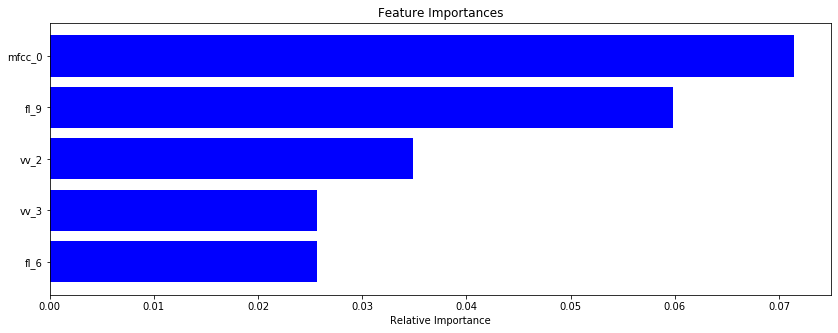

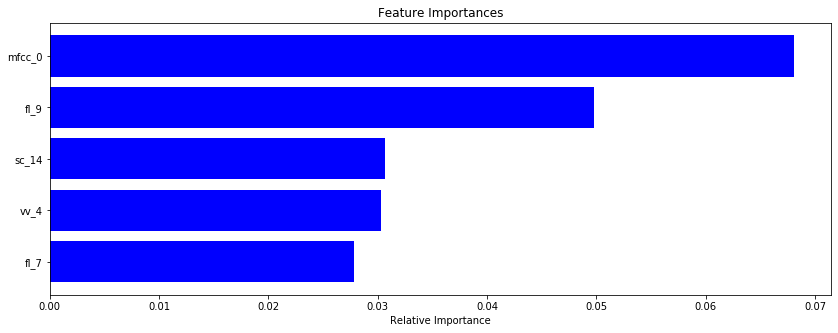

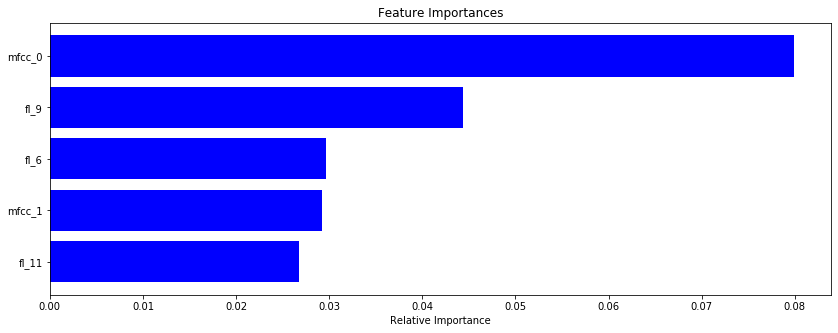

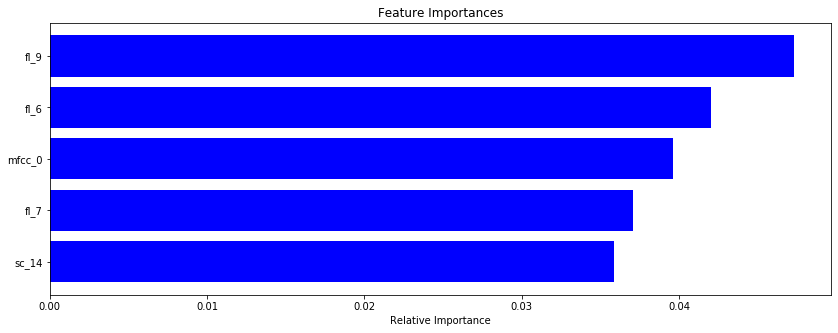

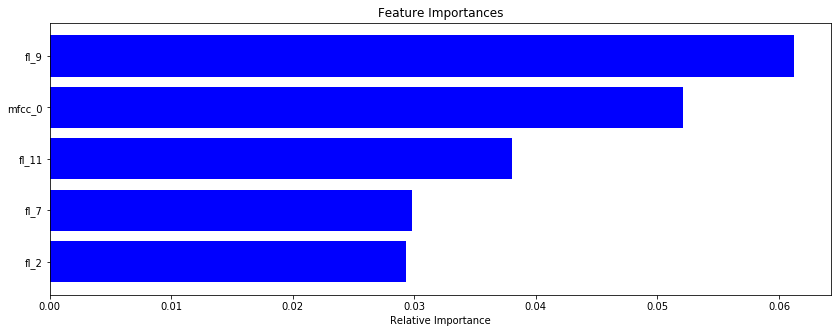

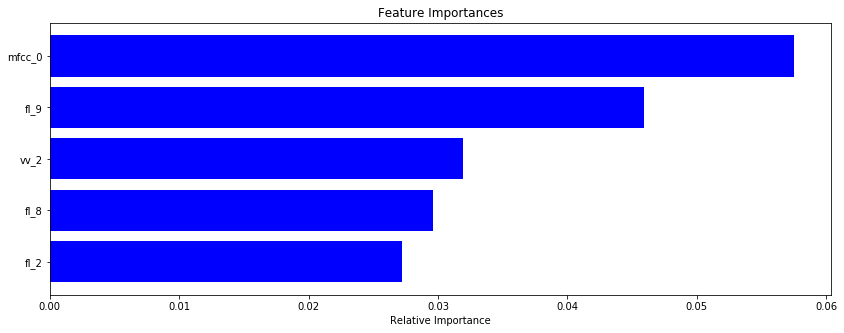

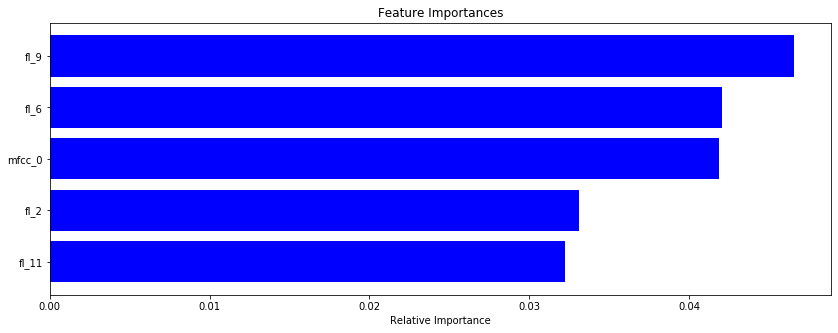

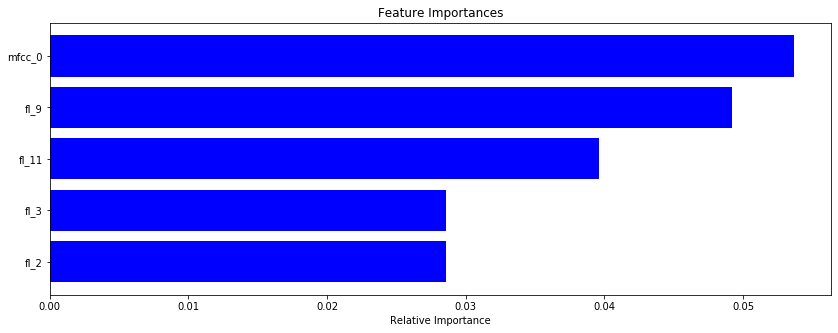

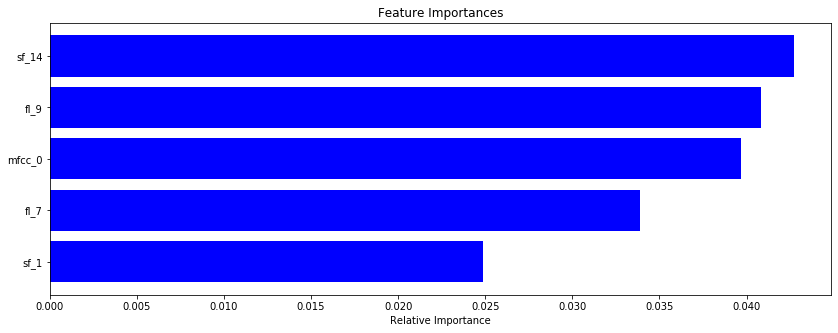

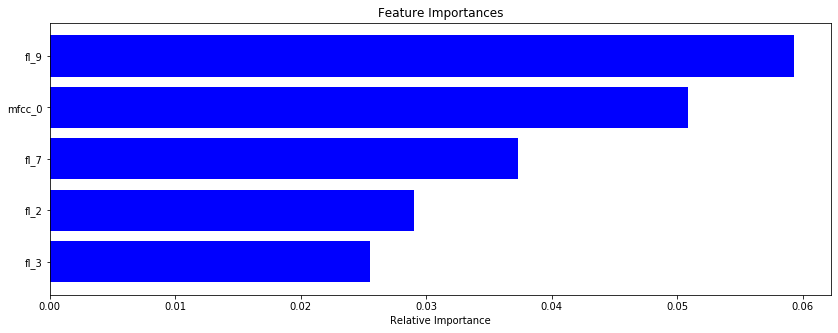

In [12]:
rows_list = []
rf_models = []
saco = []

for spl in range(10):
    # Seed for reproducibility
    np.random.seed(8536235)
    clf3=RandomForestClassifier(bootstrap=True, 
                                max_depth=30,
                                max_features='sqrt',
                                n_estimators=10)
    
    X_train, y_train = sf.read_agg_features(train_files[spl], verbose=False)
    X_test, y_test = sf.read_agg_features(test_files[spl], verbose=False)
    
    clf3.fit(X_train, y_train)
    rf_models.append(clf3)
    
    X_train_probabilities = clf3.predict_proba(X_train)[:,1]
    # Find optimal threshold from train set
    opt_tshld = optimal_threshold(X_train_probabilities, y_train)
    
    for piece_name in tqdm(test_files[spl]):
        piece_features, piece_labels = sf.read_agg_features([piece_name], verbose=False)

        proba = clf3.predict_proba(piece_features)
        proba = proba[:,1]

        #
        pred_labels = clf3.predict(piece_features)
        acc = sklearn.metrics.accuracy_score(piece_labels, pred_labels)
        P,R,F1,_ = precision_recall_fscore_support(piece_labels, pred_labels, average='binary')
        rows_list.append({'split':spl,
                          'piece':piece_name,
                          'type':'output',
                          'opt_tshld':opt_tshld,
                          'ACC':acc,
                          'P':P,'R':R,'F1':F1})

        #
        pred_filt = scipy.signal.medfilt(pred_labels,kernel_size=5)
        acc = sklearn.metrics.accuracy_score(piece_labels, pred_filt)
        P,R,F1,_ = precision_recall_fscore_support(piece_labels, pred_filt, average='binary')
        rows_list.append({'split':spl,
                          'piece':piece_name,
                          'type':'smooth output',
                          'opt_tshld':opt_tshld,
                          'ACC':acc,
                          'P':P,'R':R,'F1':F1})
        
                #
        thresh = even_median_filter(proba,kernel=4)
        #thresh = scipy.signal.medfilt(proba,kernel_size=5)
        thresh = np.where(scipy.signal.medfilt(thresh,kernel_size=5) >= 0.5,1,0)
        acc = sklearn.metrics.accuracy_score(piece_labels, thresh)
        P,R,F1,_ = precision_recall_fscore_support(piece_labels, thresh, average='binary')
        rows_list.append({'split':spl,
                          'piece':piece_name,
                          'type':'majority vote',
                          'opt_tshld':opt_tshld,
                          'ACC':acc,
                          'P':P,'R':R,'F1':F1})

        #
        thresh = even_median_filter(proba,kernel=4)
        #thresh = scipy.signal.medfilt(proba,kernel_size=5)
        thresh = np.where(scipy.signal.medfilt(thresh,kernel_size=5) >= opt_tshld,1,0)
        acc = sklearn.metrics.accuracy_score(piece_labels, thresh)
        P,R,F1,_ = precision_recall_fscore_support(piece_labels, thresh, average='binary')
        rows_list.append({'split':spl,
                          'piece':piece_name,
                          'type':'optimal binarization',
                          'opt_tshld':opt_tshld,
                          'ACC':acc,
                          'P':P,'R':R,'F1':F1})

        # Plot all together
#         sns.set_style(style='white')
#         plt.figure(figsize=(14,3))
#         plt.plot(piece_labels+2)
#         plt.plot(pred_labels+1)
#         plt.plot(pred_filt)
#         plt.plot(proba-1)
#         plt.plot(scipy.signal.medfilt(proba,kernel_size=5)-2)
#         plt.plot(thresh-3)
#         plt.legend(['Original Label', 'Predicted Label', 'Filter Prediction', 
#                     'Probabilities', 'Filter Probabilities', 'Threshold Prob'], bbox_to_anchor=(1, 1))

    plt.figure(figsize=(14,5))
    importances = clf3.feature_importances_
    indices = np.argsort(importances)

    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices))[111:], importances[indices][111:], color='b', align='center')
    plt.yticks(range(len(indices))[111:], features[indices][111:])
    saco += [x for x in features[indices][111:]]
    plt.xlabel('Relative Importance')
    plt.show()
    

In [13]:
results_rf = pd.DataFrame(rows_list)

In [14]:
results_rf = results_rf.sort_values(['ACC','piece'])

In [15]:
results_rf['opt_tshld'] = round(results_rf['opt_tshld'],5)

In [33]:
pieces_chosen = ['CelestialShore_DieForUs', 
                 'BigTroubles_Phantom', 
                 'PurlingHiss_Lolita',
                 'AlexanderRoss_GoodbyeBolero',
                 'Auctioneer_OurFutureFaces']

df_melt = pd.melt(results_rf[results_rf['piece'].isin(pieces_chosen)], 
                  id_vars=['type','piece'], 
                  value_vars=['ACC','P','R','F1'],
                  var_name='metric', value_name='value')

(0, 1)

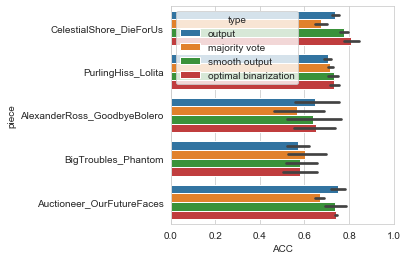

In [112]:
plt.figure(figsize=(4,4))
g = sns.barplot(y='piece', x='ACC', hue='type',hue_order=['output','majority vote','smooth output','optimal binarization'], data=results_rf[results_rf['piece'].isin(pieces_chosen)])
g.set_xlim(0,1,0.5)

In [151]:
sns.set_style("whitegrid")

[(0.0, 1.05)]

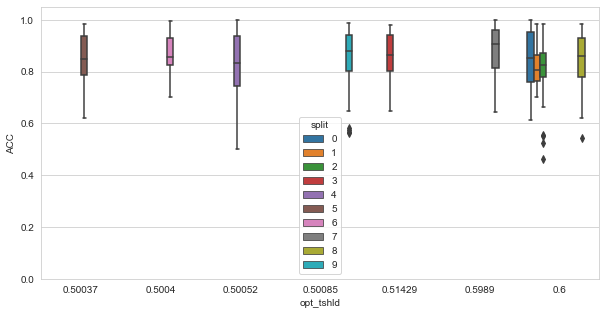

In [101]:
plt.figure(figsize=(10,5))
g = sns.boxplot(x='opt_tshld', y='ACC', hue='split', data=results_rf)
g.set(ylim=(0.0,1.05))

In [67]:
results_rf[results_rf['piece'].isin(pieces_chosen)]

,split,piece,type,opt_tshld,ACC,P,R,F1
4,0,CelestialShore_DieForUs,output,0.600000,0.722182,0.549801,0.896104,0.681481
5,0,CelestialShore_DieForUs,smooth output,0.600000,0.759512,0.586395,0.932900,0.720134
6,0,CelestialShore_DieForUs,majority vote,0.600000,0.648959,0.485149,0.954545,0.643326
7,0,CelestialShore_DieForUs,optimal binarization,0.600000,0.777459,0.611765,0.900433,0.728546
48,0,PurlingHiss_Lolita,output,0.600000,0.724434,0.651297,0.802842,0.719173
49,0,PurlingHiss_Lolita,smooth output,0.600000,0.758782,0.674931,0.870337,0.760279
50,0,PurlingHiss_Lolita,majority vote,0.600000,0.720531,0.619603,0.943162,0.747887
51,0,PurlingHiss_Lolita,optimal binarization,0.600000,0.763466,0.690616,0.836590,0.756627
124,1,PurlingHiss_Lolita,output,0.600000,0.718970,0.662921,0.733570,0.696459
125,1,PurlingHiss_Lolita,smooth output,0.600000,0.750195,0.694400,0.770870,0.730640


In [157]:
sns.set_style('whitegrid')

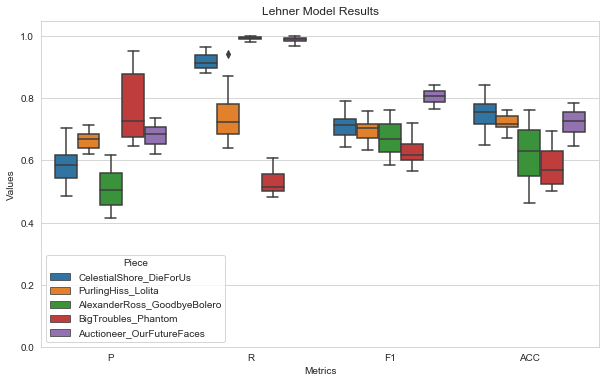

In [152]:
plt.figure(figsize=(10,6))
plt.title('Lehner Model Results')
g = sns.boxplot(data=df_melt,x='metric',y='value',order=['P','R','F1','ACC'],hue='piece')
g.set(ylim=(0.0,1.05))
g.set(xlabel='Metrics', ylabel='Values')
plt.legend(title='Piece')
plt.show()

In [ ]:
plt.figure(figsize=(8,20))
sns.barplot(y='piece', x='ACC', hue='type', data=results_rf)

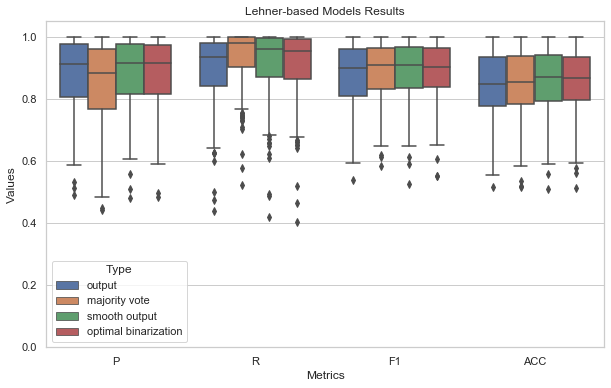

In [22]:
df_melt = pd.melt(results_rf, id_vars=['type'], value_vars=['ACC','P','R','F1'],var_name='metric', value_name='value')

df_melt = df_melt.sort_values('type',ascending=True)
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
plt.title('Lehner-based Models Results')
g = sns.boxplot(data=df_melt,
                hue='type', hue_order=['output','majority vote','smooth output','optimal binarization'],
                x='metric',y='value',order=['P','R','F1','ACC'])
g.set(ylim=(0.0,1.05))
g.set(xlabel='Metrics', ylabel='Values')
plt.legend(title='Type')
plt.show()

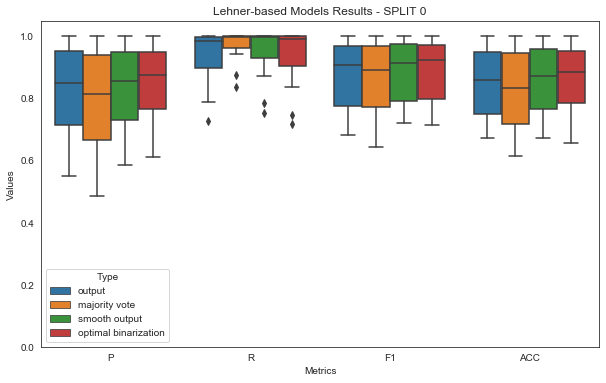

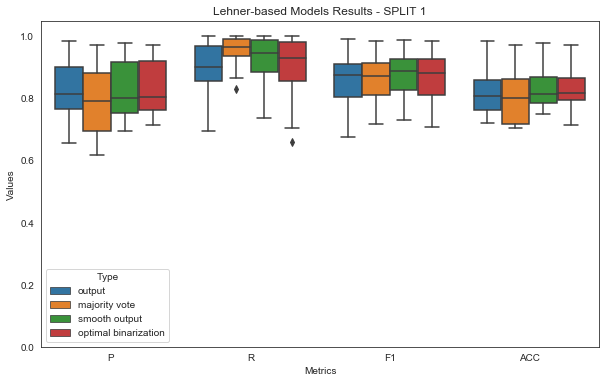

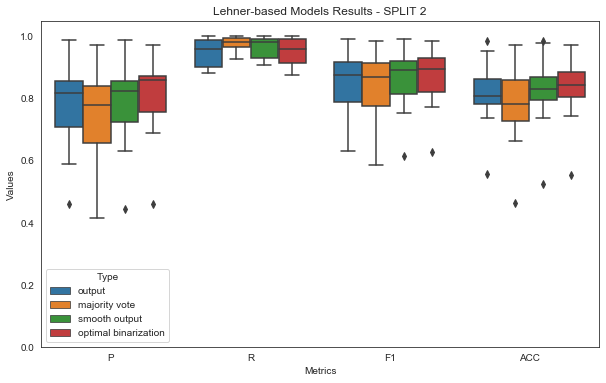

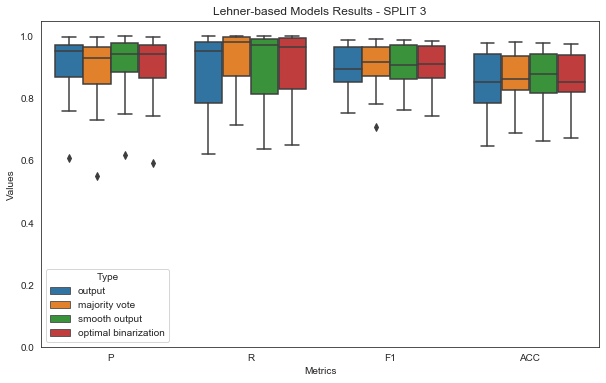

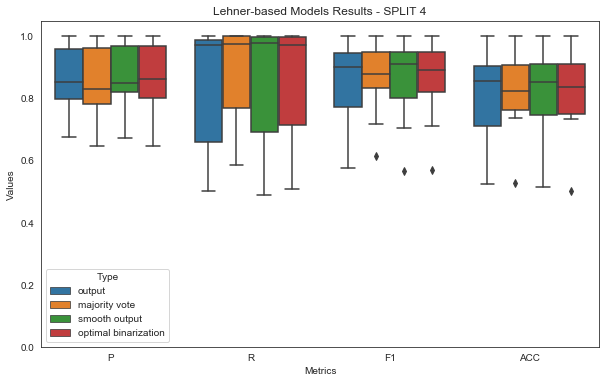

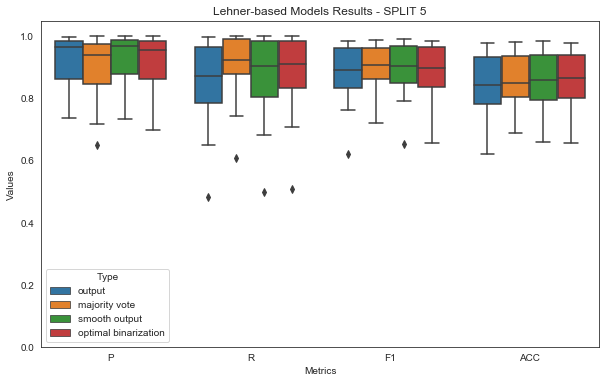

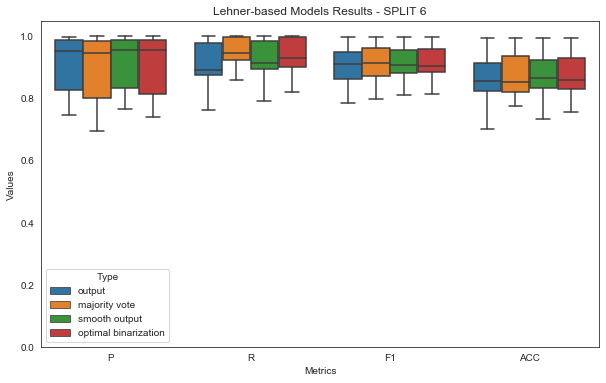

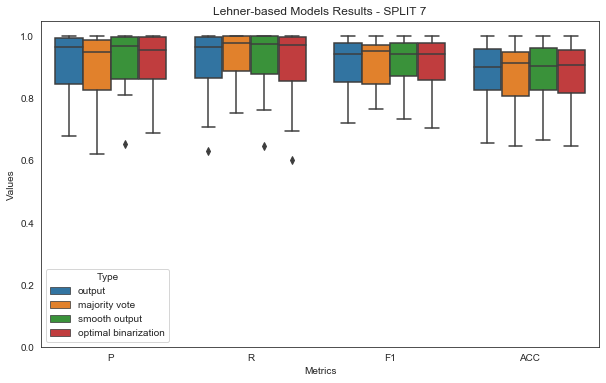

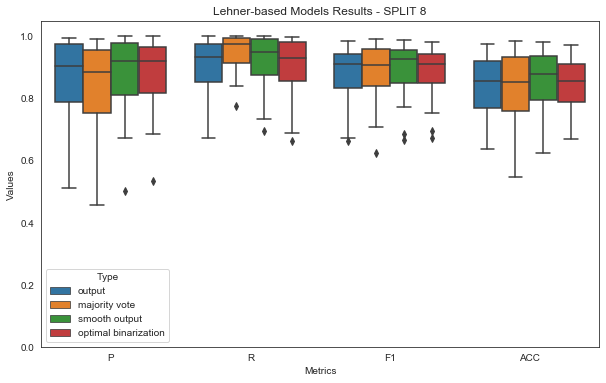

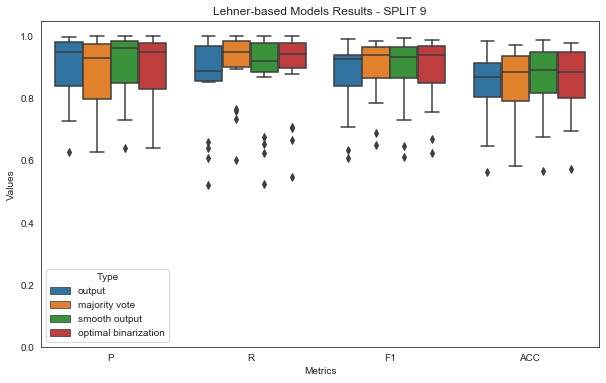

In [73]:
for split in range(10):
    df_melt = pd.melt(results_rf[results_rf['split']==split], id_vars=['type'], value_vars=['ACC','P','R','F1'],var_name='metric', value_name='value')

    df_melt = df_melt.sort_values('type',ascending=True)

    plt.figure(figsize=(10,6))
    plt.title('Lehner-based Models Results - SPLIT {}'.format(split))
    g = sns.boxplot(data=df_melt,
                    hue='type', hue_order=['output','majority vote','smooth output','optimal binarization'],
                    x='metric',y='value',order=['P','R','F1','ACC'])
    g.set(ylim=(0.0,1.05))
    g.set(xlabel='Metrics', ylabel='Values')
    plt.legend(title='Type')
    plt.show()

In [16]:
results_rf = results_rf.sort_values(by=['F1','piece'])

In [17]:
results_rf_mean = results_rf.groupby(['piece']).mean().reset_index()

In [20]:
results_rf_mean = results_rf_mean.sort_values(by=['F1'])

[(0.0, 1.0)]

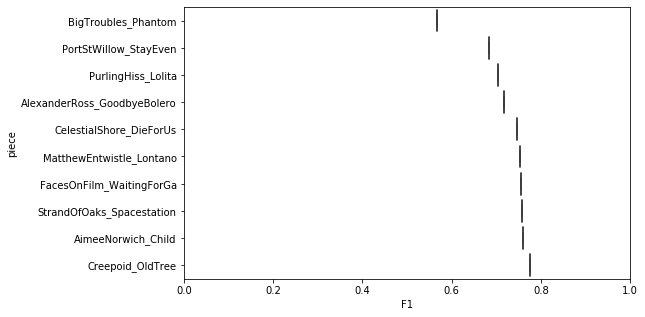

In [21]:
plt.figure(figsize=(8,5))
g= sns.boxplot(y='piece', x='F1', data=results_rf_mean.head(10))
g.set(xlim=(0.0,1.0))

In [ ]:
plt.figure(figsize=(14,15))
sns.barplot(y='piece', x='ACC', hue='type', data=results_rf[results_rf['ACC']>0.95])

Text(0.5, 0, 'Relative Importance')

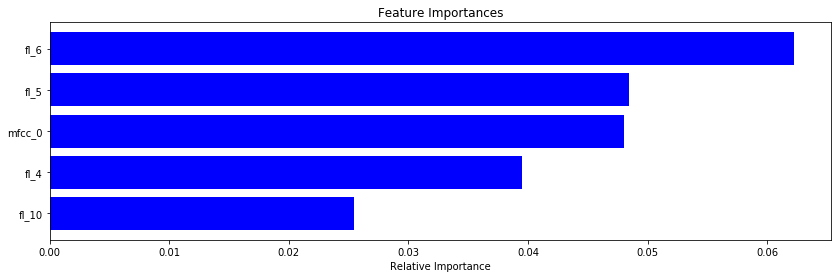

In [25]:
plt.figure(figsize=(14,4))

features = np.arange(116) # mfcc[idx], vv[idx], fl[idx], flat[idx], cont[idx]
features = ['mfcc_'+str(i) for i in range(30)]+['dt_mfcc_'+str(i) for i in range(30)]+['vv_'+str(i) for i in range(5)]
features += ['fl_'+str(i) for i in range(17)]+['sf_'+str(i) for i in range(17)]+['sc_'+str(i) for i in range(17)]
features = np.array(features)
importances = clf3.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices))[111:], importances[indices][111:], color='b', align='center')
plt.yticks(range(len(indices))[111:], features[indices][111:])
plt.xlabel('Relative Importance')

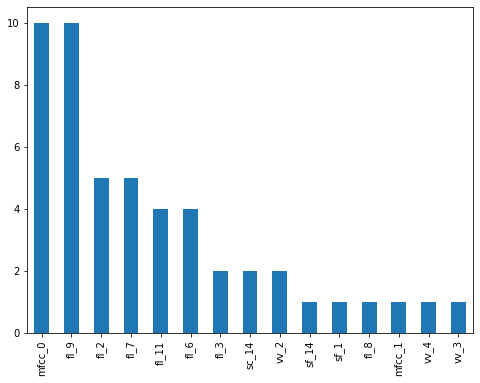

In [17]:
from collections import Counter
plt.figure(figsize=(8,6))

pd.Series(Counter(saco)).sort_values(ascending=False).plot(kind='bar')

In [19]:
df_dist = pd.DataFrame(X_train, columns=features)
df_dist['label'] = y_train

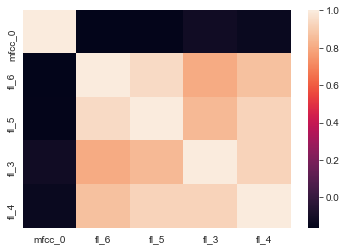

In [172]:
sns.heatmap(data=df_dist.loc[df_dist.label==0][['mfcc_0', 'fl_6', 'fl_5', 'fl_3', 'fl_4']].corr())

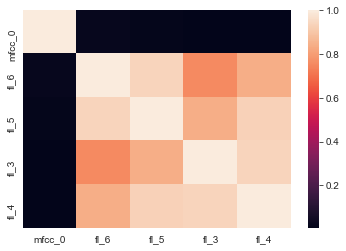

In [175]:
sns.heatmap(data=df_dist.loc[df_dist.label==1][['mfcc_0', 'fl_6', 'fl_5', 'fl_3', 'fl_4']].corr())

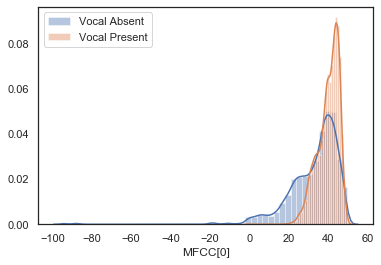

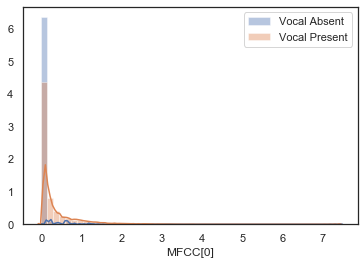

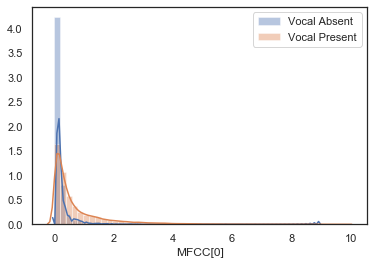

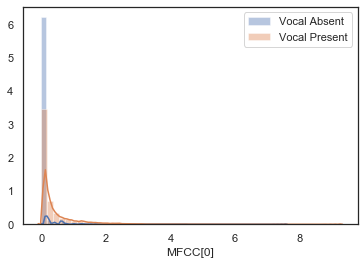

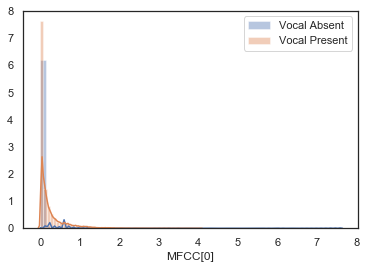

In [26]:
for coef in ['mfcc_0', 'fl_9', 'fl_2', 'fl_7', 'fl_11']:
    sns.distplot(df_dist.loc[df_dist.label==0][coef])
    sns.distplot(df_dist.loc[df_dist.label==1][coef])
    plt.legend(['Vocal Absent ', 'Vocal Present'])
    plt.xlabel('MFCC[0]')
    plt.show()

Text(3.8, 4.5, 'presente')

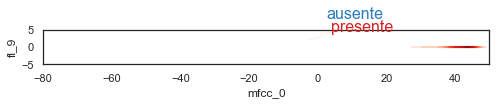

In [29]:
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(df_dist.loc[df_dist.label==0]['mfcc_0'], df_dist.loc[df_dist.label==0]['fl_9'],
                 cmap="Blues", shade=True, shade_lowest=False)
ax = sns.kdeplot(df_dist.loc[df_dist.label==1]['mfcc_0'], df_dist.loc[df_dist.label==1]['fl_9'],
                 cmap="Reds", shade=False, shade_lowest=False)
ax.set(ylim=(-5, 5))
ax.set(xlim=(-80, 50))
# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(2.5, 8.2, "ausente", size=16, color=blue)
ax.text(3.8, 4.5, "presente", size=16, color=red)

In [165]:
pieces_chosen

['CelestialShore_DieForUs',
 'BigTroubles_Phantom',
 'PurlingHiss_Lolita',
 'AlexanderRoss_GoodbyeBolero',
 'Auctioneer_OurFutureFaces']

In [39]:
# Usar o melhor resultado de F1 para mostrar o gráfico de classificação dos trechos cantados
piece_name = pieces_chosen[0]
split = 2
piece_features, piece_labels = sf.read_agg_features([piece_name], verbose=False)
pred_labels = rf_models[split].predict(piece_features)

In [40]:
results_rf[results_rf['split']==split].opt_tshld.mean()

0.6000000000000008

In [41]:
proba = rf_models[split].predict_proba(piece_features)[:,1]

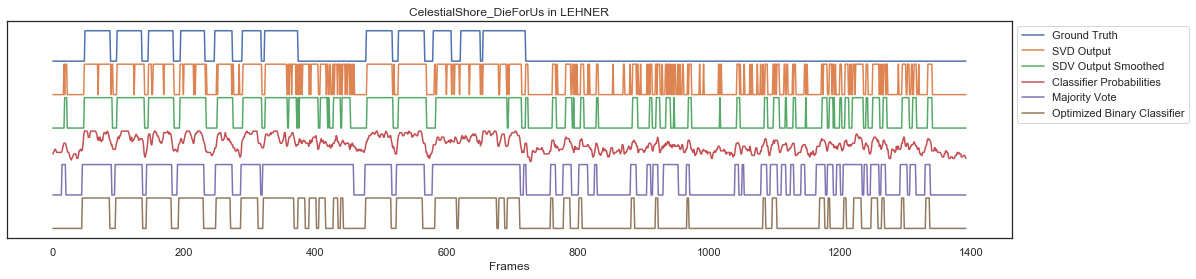

In [43]:
sns.set_style(style='white')
plt.figure(figsize=(18,4))
plt.title(piece_name+ ' in LEHNER')

plt.plot(piece_labels+2.2)
plt.plot(pred_labels+1.1)
plt.plot(scipy.signal.medfilt(pred_labels,kernel_size=5))
plt.plot(proba-1.1)
proba = even_median_filter(proba,kernel=4)
#plt.plot(proba-2)
thresh = np.where(scipy.signal.medfilt(proba,kernel_size=5) >= 0.5,1,0)
plt.plot(thresh-2.2)
opt_tsh = results_rf[results_rf['split']==split].opt_tshld.mean()
thresh = np.where(scipy.signal.medfilt(proba,kernel_size=5) >= opt_tsh,1,0)
plt.plot(thresh-3.3)
plt.yticks([])
plt.xlabel('Frames')

plt.legend(['Ground Truth', 'SVD Output', 'SDV Output Smoothed', #'Classifier Probabilities', 
            'Classifier Probabilities', 'Majority Vote', 'Optimized Binary Classifier'], bbox_to_anchor=(1, 1))

In [38]:
results_rf[(results_rf['piece']==pieces_chosen[0])&(results_rf['split']==2)]

,split,piece,type,opt_tshld,ACC,P,R,F1
154,2,CelestialShore_DieForUs,majority vote,0.6,0.697057,0.523095,0.980519,0.682229
152,2,CelestialShore_DieForUs,output,0.6,0.759512,0.588317,0.915584,0.716342
153,2,CelestialShore_DieForUs,smooth output,0.6,0.783202,0.611421,0.950216,0.744068
155,2,CelestialShore_DieForUs,optimal binarization,0.6,0.816942,0.657056,0.937229,0.772525


In [167]:
results_rf[results_rf['piece'].isin(pieces_chosen)]

,split,piece,type,opt_tshld,ACC,P,R,F1
606,8,AlexanderRoss_GoodbyeBolero,majority vote,0.600000,0.534384,0.449406,0.998744,0.619883
142,2,AlexanderRoss_GoodbyeBolero,majority vote,0.600000,0.535817,0.450113,0.997487,0.620313
307,4,BigTroubles_Phantom,optimal binarization,0.500775,0.550409,0.689295,0.555789,0.615385
306,4,BigTroubles_Phantom,majority vote,0.500775,0.555858,0.666667,0.627368,0.646421
304,4,BigTroubles_Phantom,output,0.500775,0.574932,0.719677,0.562105,0.631206
305,4,BigTroubles_Phantom,smooth output,0.500775,0.576294,0.721622,0.562105,0.631953
141,2,AlexanderRoss_GoodbyeBolero,smooth output,0.600000,0.594078,0.483557,0.997487,0.651354
692,9,BigTroubles_Phantom,output,0.582143,0.600817,0.780864,0.532632,0.633292
695,9,BigTroubles_Phantom,optimal binarization,0.582143,0.606267,0.829787,0.492632,0.618230
605,8,AlexanderRoss_GoodbyeBolero,smooth output,0.600000,0.609360,0.493176,0.998744,0.660299
